In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs

# Effect of a ramp stimulus on a leaky capacitor

To develop a toy model of the peak population firing rate evoked by a ramp stimulus with a given derivative, we'll begin by considering the voltage created when this stimulus is applied to a non-spiking neuron (aka, a leaky capacitor). The membrane filter of our non-spiking neuron is $\kappa(t) = \alpha e^{-t/\tau_m}$, where $\tau_m$ is the membrane time constant and $\alpha = 1/C$ is a scaling factor. The voltage created by passing a time-dependent current $I(t)$ through our membrane filter is $$V(t) = (\kappa * I)(t) =  \int_{-\infty}^t \kappa(t - \tau) I(\tau) d\tau,$$ where $\tau$ is a lag.

Consider the time-dependent input $I$ to be a ramp stimulus of a fixed amplitude $A$ starting at time 0 and lasting until time $t^\prime$. The derivative of $I$ is defined as follows
\begin{equation}
    \frac{dI}{dt} = 
    \begin{cases}
        0 & -\infty < t < 0 \\
        A/t^\prime & 0 < t < t^\prime.
    \end{cases}
\end{equation}
Using this definition of $\frac{dI}{dt}$, we can integrate the definition of $V(t)$ above and obtain the following as the voltage at the end of the ramp 
$$V(t^\prime) = R_m A \left[1 - \frac{\tau_m}{t^\prime}(1 - e^{-t^\prime/\tau_m})\right],$$
where $R_m = \alpha \tau_m$. Notice that this equation meets a couple of basic intuitions about the voltage evoked by the ramp:

- when the ramp is very long ($t^\prime \gg \tau_m$), this reduces to Ohm's law $V = A R_m$
- when the ramp is short ($t^\prime < \tau_m$), the final voltage $V(t^\prime)$ is less than what you'd get from Ohm's law because the membrane filter hasn't fully integrated the stimulus.

Notice also that since $\frac{dI}{dt}$ is inversely proportional to $t^\prime$, this equation also tells us that increasing $\frac{dI}{dt}$ (aka decreasing $t^\prime$) reduces the voltage.

If we plot this equation in terms of $\tau_m/t^\prime$, we can see how much ramps with different durations (aka derivatives) affect the membrane voltage.

In [2]:
def v_final(tau_duration_ratio):
    return (
        1 - tau_duration_ratio * (1 - np.exp(-1./tau_duration_ratio))
    )

Text(0,0.5,'Peak voltage (AU)')

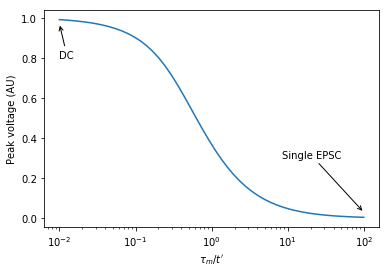

In [3]:
tau_duration_ratio = np.logspace(-2, 2)
plt.semilogx(tau_duration_ratio, v_final(tau_duration_ratio))
plt.annotate('DC', (0.01, 0.97), (0.01, 0.8), arrowprops={'arrowstyle': '->'})
plt.annotate('Single EPSC', 
             (100, 0.03), (50, 0.3), arrowprops={'arrowstyle': '->'},
            ha='right')
plt.xlabel(r'$\tau_m/t^\prime$')
plt.ylabel('Peak voltage (AU)')

A sigmoid on a log scale! As expected, DC currents affect the voltage very much, but short ramps are filtered out.

To help with getting an intuition for this curve, consider a 5-HT neuron with $\tau_m = 50$ms. Ramps longer than 0.5s are basically DC, and ramps shorter than 5ms are completely filtered out.

The ramp simulations I ran all fall on the left hand side of this plot, since the shortest ramps there are 100ms. Here's what that part of the curve looks like using the same parameters as my simulations.

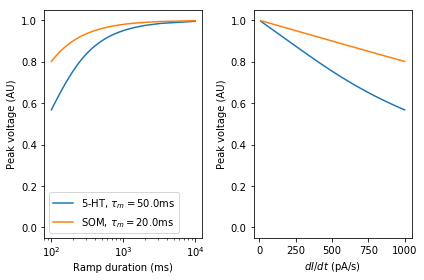

In [4]:
derivatives = np.linspace(10, 1000)  # pA/s
ramp_amplitude = 100.  # pA
durations = ramp_amplitude / derivatives * 1e3  # ms

dur_ax = plt.subplot(121)
plt.ylabel('Peak voltage (AU)')
plt.xlabel('Ramp duration (ms)')
plt.ylim(-0.05, 1.05)

deriv_ax = plt.subplot(122)
plt.xlabel('$dI/dt$ (pA/s)')
plt.ylabel('Peak voltage (AU)')
plt.ylim(-0.05, 1.05)

for label, time_constant in {'SOM': 20., '5-HT': 50.}.items():
    dur_ax.semilogx(
        durations, 
        v_final(time_constant / durations), 
        label='{}, $\\tau_m = {}$ms'.format(label, time_constant)
    )
    
    deriv_ax.plot(derivatives, v_final(time_constant / durations))
    
dur_ax.legend()
plt.tight_layout()

Notice that if we look at the same range of values for SOM neurons, which have a shorter time constant, the curve looks flatter.

You can see this effect over a wide range of choices of $\tau_m$ in the heatmap below.

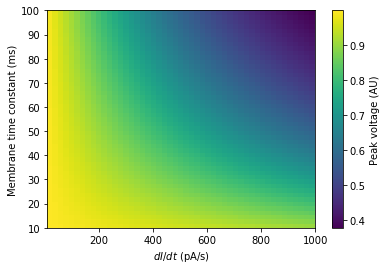

In [5]:
time_constants = np.linspace(10, 100)
final_voltages = [
    v_final(time_constant/durations)
    for time_constant in time_constants
]

plt.subplot(111)
mappable = plt.pcolormesh(
    derivatives,
    time_constants,
    final_voltages
)
plt.ylabel('Membrane time constant (ms)')
plt.xlabel('$dI/dt$ (pA/s)')

cbar = plt.gcf().colorbar(mappable)
cbar.set_label('Peak voltage (AU)')

## Summary of effect of ramp stimulus on voltage

Ramps shorter than the membrane time constant are filtered out. This probably shows up more in my simulations of 5-HT neurons than SOM cells because their time constants are longer.

# Translating voltage into a firing rate

## Mathematical details

A LIF neuron with spike threshold $\theta$ and reset potential 0mV receiving a DC input $I$ spikes at the following rate
$$ \rho = \frac{-1}{\tau_m \log (1 - \frac{\theta}{IR_m})}, $$
which is the reciprocal of the ISI. I'll use this as a zero-order approximation of the population firing rate associated with the voltages calculated above.

First, though, notice that this rate is mainly a function of the strength of the input relative to spike threshold $\theta/(IR_m)$. What does that look function look like?

In [6]:
def rate(time_constant, threshold_ratio):
    denominator = time_constant * np.log(1. - threshold_ratio)
    return -1. / denominator

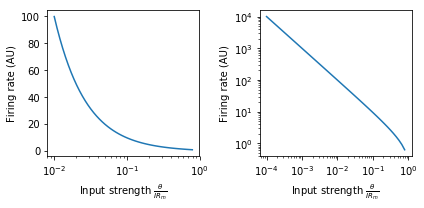

In [7]:
plt.figure(figsize=(6, 3))

plt.subplot(121)
threshold_ratios = np.logspace(-2, -0.1)
plt.semilogx(
    threshold_ratios, 
    rate(1., threshold_ratios),
)
plt.ylabel('Firing rate (AU)')
plt.xlabel(r'Input strength $\frac{\theta}{IR_m}$')

plt.subplot(122)
threshold_ratios = np.logspace(-4, -0.1)
plt.loglog(
    threshold_ratios, 
    rate(1., threshold_ratios),
)
plt.ylabel('Firing rate (AU)')
plt.xlabel(r'Input strength $\frac{\theta}{IR_m}$')

plt.tight_layout()

Power law, more or less!

So, what happens when we substitute in the $V(t^\prime)$ we calculated earlier?
$$\frac{\theta}{IR_m} = \frac{\theta}{V(t^\prime)} = \frac{\theta}{AR_mx},$$
where $x$ is the output of the `v_final()` function I used above. I'll call $\frac{\theta}{AR_m}$ the `threshold_ratio` below.

/home/eharkin/miniconda3/envs/neopozz/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


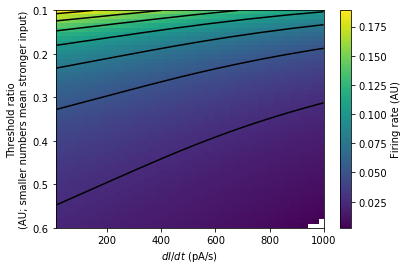

In [8]:
time_constant = 50.
threshold_ratios = np.linspace(0.1, 0.6)  # Small numbers mean big input.
voltage_multipliers = v_final(time_constant / durations)
firing_rates = [
    rate(time_constant, threshold_ratio / voltage_multipliers)
    for threshold_ratio in threshold_ratios
]

mappable = plt.pcolormesh(derivatives, threshold_ratios, firing_rates)
plt.contour(derivatives, threshold_ratios, firing_rates, colors='k')
plt.gca().invert_yaxis()
plt.ylabel('Threshold ratio\n(AU; smaller numbers mean stronger input)')
plt.xlabel('$dI/dt$ (pA/s)')

cbar = plt.gcf().colorbar(mappable)
cbar.set_label('Firing rate (AU)')

Notice that we're seeing the diagonal structure of the firing rate contour plot for the first time!

A few squares are missing in the bottom right because these inputs don't quite reach threshold.

Since the firing rate formula is scale-free/power law, this diagonal structure shows up for any choice of `threshold_ratio`.

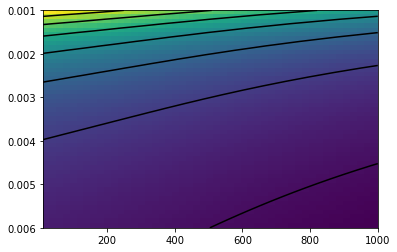

In [9]:
threshold_ratios = np.linspace(0.001, 0.006)  # Small numbers mean big input.
voltage_multipliers = v_final(time_constant / durations)
firing_rates = [
    rate(time_constant, threshold_ratio / voltage_multipliers)
    for threshold_ratio in threshold_ratios
]

plt.pcolormesh(derivatives, threshold_ratios, firing_rates)
plt.contour(derivatives, threshold_ratios, firing_rates, colors='k')
plt.gca().invert_yaxis()

## Membrane time constant controls diagonal structure

The diagonal structure of the firing rate vs. "threshold ratio" (can be interpreted roughly as **distance to threshold**) and input derivative plots above depends very much on the membrane time constant: there's very little diagonal structure when the membrane time constant is low (ie SOM neurons).

/home/eharkin/miniconda3/envs/neopozz/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


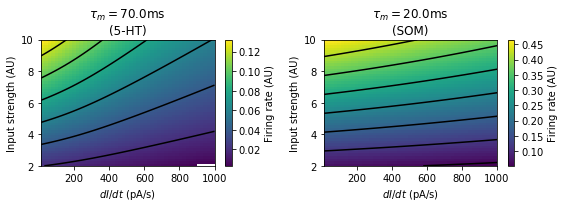

In [10]:
plt.figure(figsize=(8, 3))
for i, (label, time_constant) in enumerate({'5-HT': 70., 'SOM': 20.}.items()):
    input_strengths = np.linspace(2, 10)
    voltage_multipliers = v_final(time_constant / durations)
    firing_rates = [
        rate(time_constant, 1. / (input_strength * voltage_multipliers))
        for input_strength in input_strengths
    ]

    plt.subplot(1, 2, i+1)
    plt.title('$\\tau_m = {}$ms\n({})'.format(time_constant, label))
    mappable = plt.pcolormesh(derivatives, input_strengths, firing_rates)
    plt.contour(derivatives, input_strengths, firing_rates, colors='k')
    plt.ylabel('Input strength (AU)')
    plt.xlabel('$dI/dt$ (pA/s)')

    cbar = plt.gcf().colorbar(mappable)
    cbar.set_label('Firing rate (AU)')
    
plt.tight_layout()

This shows how the toy model can explain the diagonal structure of the contour plots from the simulations.

# Capturing the effect of adaptation

Adaptation divisively reduces the firing rate. This is derivative-dependent. We can capture this phenomenologically by multiplying the firing rates generated above with a sigmoid function of $dI/dt$.

In [11]:
def get_sigmoid(slope, offset):
    def sigmoid(arr):
        return 1. / (1 + np.exp(-slope * (arr - offset)))
    return sigmoid

/home/eharkin/miniconda3/envs/neopozz/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


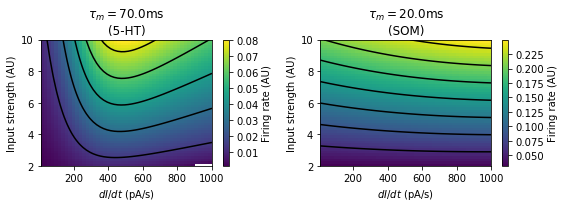

In [12]:
cell_params = {
    '5-HT': {
        'time_constant': 70.,
        'sigmoid': get_sigmoid(0.01, 250.),
    },
    'SOM': {
        'time_constant': 20.,
        'sigmoid': get_sigmoid(0.001, 250.)
    }
}

plt.figure(figsize=(8, 3))
for i, (label, params) in enumerate(cell_params.items()):
    input_strengths = np.linspace(2, 10)
    voltage_multipliers = v_final(params['time_constant'] / durations)
    firing_rates = np.array([
        rate(params['time_constant'], 1. / (input_strength * voltage_multipliers))
        for input_strength in input_strengths
    ])
    firing_rates *= params['sigmoid'](derivatives)

    plt.subplot(1, 2, i+1)
    plt.title('$\\tau_m = {}$ms\n({})'.format(params['time_constant'], label))
    mappable = plt.pcolormesh(derivatives, input_strengths, firing_rates)
    plt.contour(derivatives, input_strengths, firing_rates, colors='k')
    plt.ylabel('Input strength (AU)')
    plt.xlabel('$dI/dt$ (pA/s)')

    cbar = plt.gcf().colorbar(mappable)
    cbar.set_label('Firing rate (AU)')
    
plt.tight_layout()